In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:

file_path1= "/Users/fanbu/Desktop/AI Agent for Time-Series Forecasting in Financial Planning/AI-Agent/data/India_cc_transactions.csv"

In [3]:
data = pd.read_csv(file_path1)
data

,index,City,Date,Card Type,Exp Type,Gender,Amount
0,0,"Delhi, India",29-Oct-14,Gold,Bills,F,82475
1,1,"Greater Mumbai, India",22-Aug-14,Platinum,Bills,F,32555
2,2,"Bengaluru, India",27-Aug-14,Silver,Bills,F,101738
3,3,"Greater Mumbai, India",12-Apr-14,Signature,Bills,F,123424
4,4,"Bengaluru, India",5-May-15,Gold,Bills,F,171574
...,...,...,...,...,...,...,...
26047,26047,"Kolkata, India",22-Jun-14,Silver,Travel,F,128191
26048,26048,"Pune, India",3-Aug-14,Signature,Travel,M,246316
26049,26049,"Hyderabad, India",16-Jan-15,Silver,Travel,M,265019
26050,26050,"Kanpur, India",14-Sep-14,Silver,Travel,M,88174


In [4]:
daily_card = data.groupby(['Date', 'Card Type'])['Amount'].sum().reset_index()


In [5]:
daily_card.head()

,Date,Card Type,Amount
0,1-Apr-14,Gold,1994262
1,1-Apr-14,Platinum,1517236
2,1-Apr-14,Signature,1073671
3,1-Apr-14,Silver,1533742
4,1-Apr-15,Gold,1092025


/var/folders/1s/k786dc_10bb7lpsh7_dxllpr0000gn/T/ipykernel_26509/3573073472.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Date'] = pd.to_datetime(data['Date'], errors='coerce')


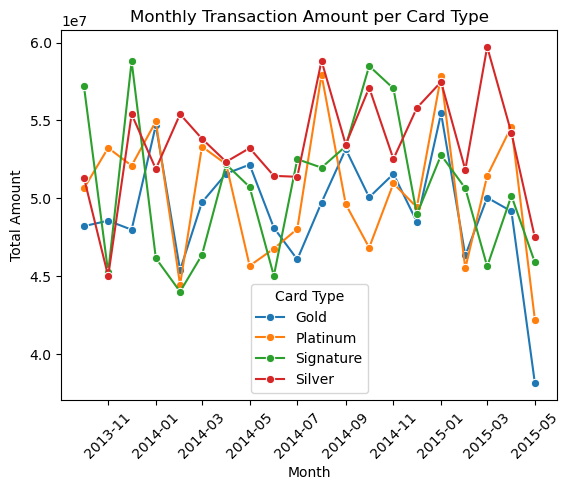

In [6]:
# Make sure your column is called 'Date'
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# Create a 'Month' column
data['Month'] = data['Date'].dt.to_period('M')
# Aggregate transaction amounts per Month and Card Type
monthly_card = data.groupby(['Month', 'Card Type'])['Amount'].sum().reset_index()

# Convert Month back to datetime (optional, useful for plotting)
monthly_card['Month'] = monthly_card['Month'].dt.to_timestamp()

sns.lineplot(data=monthly_card, x='Month', y='Amount', hue='Card Type', marker='o')
plt.title('Monthly Transaction Amount per Card Type')
plt.ylabel('Total Amount')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.show()



In [7]:
monthly_card

,Month,Card Type,Amount
0,2013-10-01,Gold,48207082
1,2013-10-01,Platinum,50634540
2,2013-10-01,Signature,57196872
3,2013-10-01,Silver,51321598
4,2013-11-01,Gold,48555781
...,...,...,...
75,2015-04-01,Silver,54190751
76,2015-05-01,Gold,38131657
77,2015-05-01,Platinum,42203610
78,2015-05-01,Signature,45879491


In [8]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing


In [9]:

# Assume daily_card has columns: 'Date', 'Card Type', 'Amount'
# Step 1: Convert Date column to datetime
daily_card['Date'] = pd.to_datetime(daily_card['Date'], errors='coerce')

# Step 2: Drop rows with invalid dates
daily_card = daily_card.dropna(subset=['Date'])

# Step 3: Reindex to include all days per Card Type
all_card_types = daily_card['Card Type'].unique()
daily_card_full = pd.DataFrame()

for card in all_card_types:
    # Filter for this Card Type
    df_card = daily_card[daily_card['Card Type'] == card].set_index('Date').sort_index()
    
    # Create a complete daily index for the period
    all_days = pd.date_range(start=df_card.index.min(), end=df_card.index.max(), freq='D')
    df_card = df_card.reindex(all_days, fill_value=0)  # Fill missing days with 0
    
    # Add Card Type column back
    df_card['Card Type'] = card
    
    # Reset index
    df_card = df_card.rename_axis('Date').reset_index()
    
    # Append to full dataframe
    daily_card_full = pd.concat([daily_card_full, df_card], ignore_index=True)

# Step 4: Sort final dataframe
daily_card_full = daily_card_full.sort_values(['Card Type', 'Date']).reset_index(drop=True)

daily_card_full.head()


/var/folders/1s/k786dc_10bb7lpsh7_dxllpr0000gn/T/ipykernel_26509/486180735.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  daily_card['Date'] = pd.to_datetime(daily_card['Date'], errors='coerce')


,Date,Card Type,Amount
0,2013-10-04,Gold,3414108
1,2013-10-05,Gold,1356783
2,2013-10-06,Gold,1454931
3,2013-10-07,Gold,1204588
4,2013-10-08,Gold,1700298


In [10]:
daily_card_full.groupby("Card Type").count()

,Date,Amount
Card Type,,
Gold,600,600
Platinum,600,600
Signature,600,600
Silver,600,600


In [11]:
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np


In [12]:

# Step 1: Filter for Gold card
gold_card = daily_card_full[daily_card_full['Card Type'] == 'Gold'].copy()

# Step 2: Ensure Date is datetime
gold_card['Date'] = pd.to_datetime(gold_card['Date'], errors='coerce')
gold_card = gold_card.dropna(subset=['Date'])

# Step 3: Set Date as index and reindex to include all days
gold_card = gold_card.set_index('Date').sort_index()
all_days = pd.date_range(start=gold_card.index.min(), end=gold_card.index.max(), freq='D')
gold_card = gold_card.reindex(all_days, fill_value=0)
gold_card.index.name = 'Date'



In [13]:
gold_card

,Card Type,Amount
Date,,
2013-10-04,Gold,3414108
2013-10-05,Gold,1356783
2013-10-06,Gold,1454931
2013-10-07,Gold,1204588
2013-10-08,Gold,1700298
...,...,...
2015-05-22,Gold,1827204
2015-05-23,Gold,1878675
2015-05-24,Gold,1188962


In [14]:
# Step 4: Split train/test
train_end = pd.Timestamp('2014-12-31')
train_df = gold_card[gold_card.index <= train_end]
test_df = gold_card[gold_card.index > train_end]


In [15]:
# Step 5: Fit Exponential Smoothing on train set
model = ExponentialSmoothing(train_df['Amount'], trend='add', seasonal='add', seasonal_periods=7)
fit = model.fit()

# Step 6: Forecast for test period
forecast = fit.forecast(len(test_df))


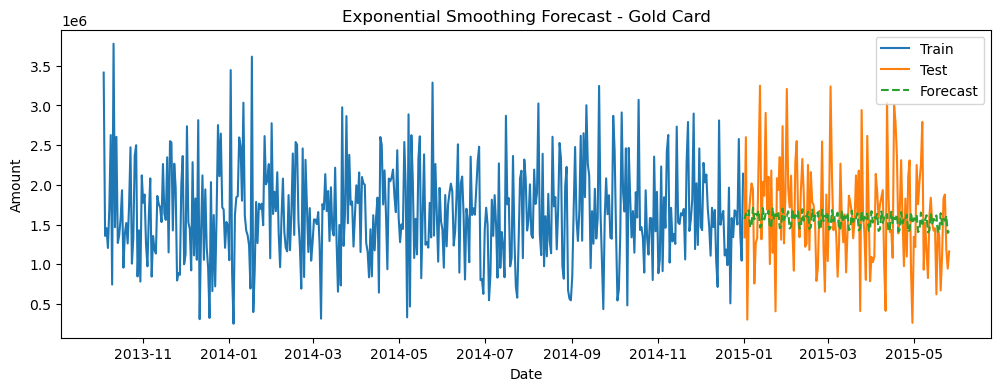

Gold Card Forecast Performance:
RMSE: 627918.92
MAE:  495591.28
MAPE: 41.75%


In [16]:



# Step 7: Plot
plt.figure(figsize=(12,4))
plt.plot(train_df.index, train_df['Amount'], label='Train')
plt.plot(test_df.index, test_df['Amount'], label='Test')
plt.plot(forecast.index, forecast, label='Forecast', linestyle='--')
plt.title('Exponential Smoothing Forecast - Gold Card')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.legend()
plt.show()

# Step 8: Evaluate

rmse = np.sqrt(mean_squared_error(test_df['Amount'], forecast))
mae = mean_absolute_error(test_df['Amount'], forecast)
mape = np.mean(np.abs((test_df['Amount'] - forecast) / (test_df['Amount'] + 1e-8))) * 100  # avoid division by zero

print(f'Gold Card Forecast Performance:')
print(f'RMSE: {rmse:.2f}')
print(f'MAE:  {mae:.2f}')
print(f'MAPE: {mape:.2f}%')

# Model Improvement: Prophet

In [17]:
from prophet import Prophet


In [29]:


# Step 1: Filter for Gold card
gold_card_prophet = daily_card_full[daily_card_full['Card Type'] == 'Gold'].copy()

# Step 2: Ensure Date is datetime
gold_card_prophet['Date'] = pd.to_datetime(gold_card_prophet['Date'], errors='coerce')
gold_card_prophet = gold_card_prophet.dropna(subset=['Date'])

# Step 3: Aggregate daily and fill missing dates
gold_card_prophet = gold_card_prophet.groupby('Date', as_index=False)['Amount'].sum()
all_days_prophet = pd.date_range(start=gold_card_prophet['Date'].min(),
                                 end=gold_card_prophet['Date'].max(),
                                 freq='D')
gold_card_prophet = (
    gold_card_prophet
    .set_index('Date')
    .reindex(all_days_prophet, fill_value=0)
    .rename_axis('Date')
    .reset_index()
)

# Step 4: Rename for Prophet
gold_card_prophet = gold_card_prophet.rename(columns={'Date': 'ds', 'Amount': 'y'})

# Step 5: Train/test split
train_df_prophet = gold_card_prophet[gold_card_prophet['ds'] <= '2014-12-31']
test_df_prophet = gold_card_prophet[gold_card_prophet['ds'] > '2014-12-31']



In [31]:

# Step 6: Fit Prophet model
model_prophet = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=0.5  # tune if needed
)
model_prophet.fit(train_df_prophet)



20:51:27 - cmdstanpy - INFO - Chain [1] start processing
20:51:28 - cmdstanpy - INFO - Chain [1] done processing


In [32]:
# ✅ Step 7: Create future dataframe that definitely covers test dates
future_prophet = model_prophet.make_future_dataframe(
    periods=len(test_df_prophet), 
    freq='D',
    include_history=True
)
forecast_prophet = model_prophet.predict(future_prophet)

# Step 8: Align forecast with test data
forecast_test_prophet = forecast_prophet[
    forecast_prophet['ds'].between(test_df_prophet['ds'].min(), test_df_prophet['ds'].max())
][['ds', 'yhat']]

# Step 9: Merge with actuals
results_prophet = test_df_prophet.merge(forecast_test_prophet, on='ds', how='inner')

# ✅ Check: Should not be empty now
print(f"Forecast rows: {len(results_prophet)}")

Forecast rows: 146


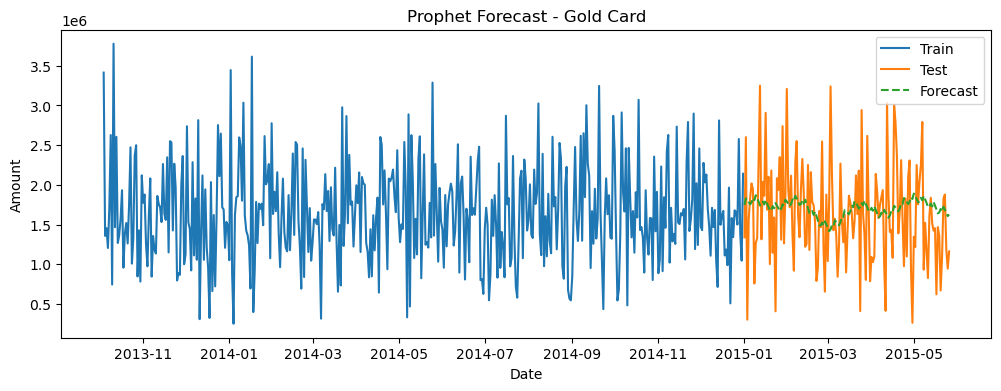

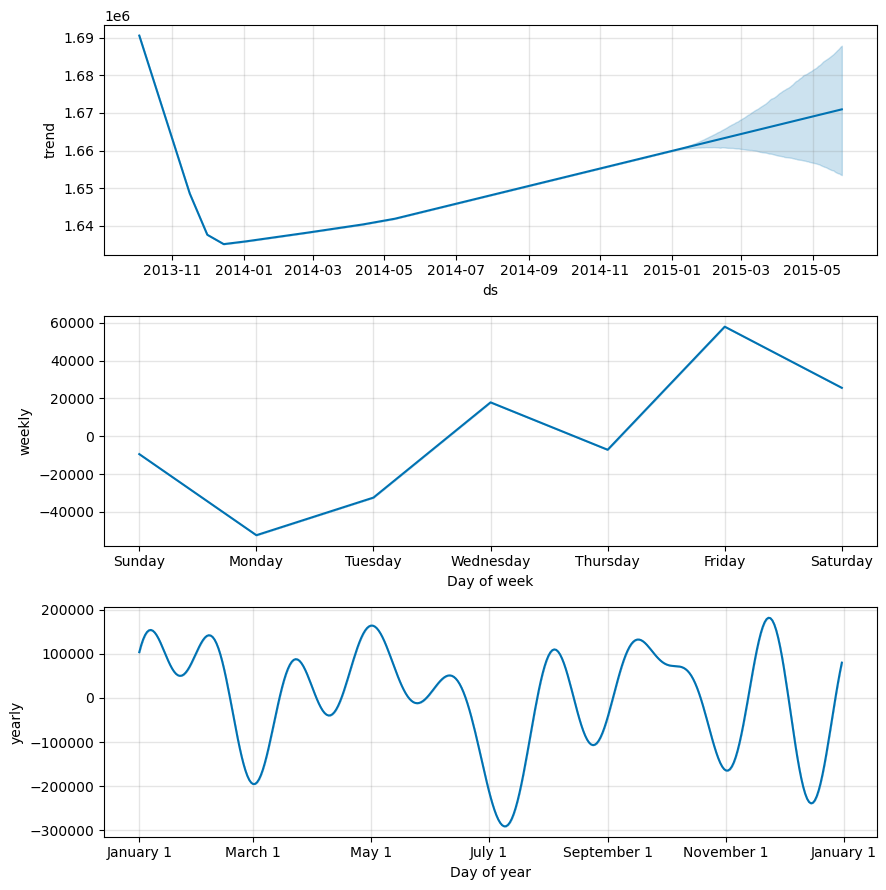

In [33]:
# Step 11: Plot
plt.figure(figsize=(12,4))
plt.plot(train_df_prophet['ds'], train_df_prophet['y'], label='Train')
plt.plot(test_df_prophet['ds'], test_df_prophet['y'], label='Test')
plt.plot(results_prophet['ds'], results_prophet['yhat'], label='Forecast', linestyle='--')
plt.title('Prophet Forecast - Gold Card')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.legend()
plt.show()

# Optional: Prophet's built-in components plot
model_prophet.plot_components(forecast_prophet)
plt.show()

In [34]:
# ✅ Check: Should not be empty now
print(f"Forecast rows: {len(results_prophet)}")

# Step 10: Evaluate
if len(results_prophet) > 0:
    rmse_prophet = np.sqrt(mean_squared_error(results_prophet['y'], results_prophet['yhat']))
    mae_prophet = mean_absolute_error(results_prophet['y'], results_prophet['yhat'])
    mape_prophet = np.mean(np.abs((results_prophet['y'] - results_prophet['yhat']) / (results_prophet['y'] + 1e-8))) * 100

    print(f"Gold Card - Prophet Forecast Performance:")
    print(f"RMSE: {rmse_prophet:.2f}")
    print(f"MAE:  {mae_prophet:.2f}")
    print(f"MAPE: {mape_prophet:.2f}%")
else:
    print("⚠️ No overlapping forecast and test dates found — check date ranges!")


Forecast rows: 146
Gold Card - Prophet Forecast Performance:
RMSE: 629323.06
MAE:  497347.63
MAPE: 45.96%
